In [1]:
%matplotlib inline

from scipy.special import voigt_profile
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
from onix.analysis.probe import Probe
from onix.analysis.fitter import Fitter
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold, present_float

In [2]:
name = "EO Spectroscopy"
analysis_number = None
identifier = None

def gaussian(f, f_0, a, sigma, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c

def gaussian2(f, a, sigma, c):
    numerator = (f - c) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator)

def voigt(f, sigma, gamma, a, c):
    return a*voigt_profile(f-c, sigma, gamma)

def get_gaussian_fit(probe):
    signal = probe.averages("flop_no_bg")
    error = probe.errors("flop_no_bg")

    fitter = Fitter(gaussian)
    fitter.set_data(probe.probes, signal, error)
    fitter.set_p0({"f_0": 0})
    fitter.set_bounds("f_0", -0.5, 0.5)
    fitter.set_bounds("a", 0, np.inf)
    fitter.set_bounds("sigma", 0, 1)
    fitter.fit()
    return fitter

def get_interpolate_fit(probe):
    signal = probe.averages("flop_no_bg")
    error = probe.errors("flop_no_bg")
    fitter = Fitter(interpolated_fit)
    fitter.set_data(probe.probes, signal, error)
    fitter.fit()
    return fitter

def get_interpolate_fit_2(probe):
    ll = len(probe.probes)//2 + 1

    detuning1 = probe.probes[:ll]
    signal1 = probe.normalized_averages("flop")[:ll] - probe.normalized_averages("antihole")[:ll]
    error1 = np.sqrt(probe.normalized_errors("flop")[:ll] ** 2 + probe.normalized_errors("antihole")[:ll] ** 2)

    detuning2 = probe.probes[ll:]
    signal2 = probe.normalized_averages("flop")[ll:] - probe.normalized_averages("antihole")[ll:]
    error2 = np.sqrt(probe.normalized_errors("flop")[ll:] ** 2 + probe.normalized_errors("antihole")[ll:] ** 2)
    
    fitter1 = Fitter(interpolated_fit1)
    fitter1.set_data(detuning1, signal1, error1)
    fitter1.set_absolute_sigma(False)
    fitter1.fit()
    
    fitter2 = Fitter(interpolated_fit2)
    fitter2.set_data(detuning2, signal2, error2)
    fitter2.set_absolute_sigma(False)
    fitter2.fit()
    
    return fitter1, fitter2

def rabi_flopping(amplitude, amplitude_to_Omega, t, a):
    return a * np.sin(amplitude * amplitude_to_Omega * t / 2) ** 2

In [3]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

In [4]:
def data_to_probe(data_number):
    data_index = data_numbers.index(data_number)
    data, headers = all_data[data_index]
    repeats = ["initial", "chasm", "antihole", "flop"]
    probe_repeats = headers["params"]["detect"]["repeats"]
    repeats = dict([(kk, 1) for kk in repeats])
    p = Probe(data["times"], data["transmissions"], repeats, data["monitors"])
    p.transmission_groups["flop_no_bg"] = p.transmission_groups["flop"] - p.transmission_groups["antihole"]
    p.monitor_groups["flop_no_bg"] = p.monitor_groups["flop"] - p.monitor_groups["antihole"]
    p.transmission_groups["antihole_no_bg"] = p.transmission_groups["antihole"] - p.transmission_groups["chasm"]
    p.monitor_groups["antihole_no_bg"] = p.monitor_groups["antihole"] - p.monitor_groups["chasm"]

    pre_probe_delay = headers["params"]["detect"]["ttl_detect_offset_time"].to("s").magnitude
    on_time = headers["params"]["detect"]["on_time"].to("s").magnitude
    off_time = headers["params"]["detect"]["off_time"].to("s").magnitude
    rise_delay = 2e-6
    fall_delay = 1e-6
    probe_detunings = headers["params"]["detect"]["detunings"].to("MHz").magnitude
    p.set_probe_times(pre_probe_delay, on_time, off_time, rise_delay, fall_delay, probe_detunings)
    return p

In [5]:
#data_arxiv = {}

In [6]:
#data_arxiv["run_6"] = (flop_times_ms, fit_amplitudes, fit_amplitude_errs)

In [313]:
phases = []
fit1_amps = []
fit1_amps_err = []
fit2_amps = []
fit2_amps_err = []

for kk in range(2151, 2403):
    all_data = [get_experiment_data(kk)]
    data_numbers = [kk]
    probe = data_to_probe(kk)
    phase = float(all_data[0][1]["params"]["flop"]["phase_difference"])
    fitter = get_interpolate_fit_2(probe)
    fit1_amp = fitter[0].results["a1"]
    fit1_amp_err = fitter[0].errors["a1"]
    fit2_amp = fitter[1].results["a2"]
    fit2_amp_err = fitter[1].errors["a2"]
    phases.append(phase)
    fit1_amps.append(fit1_amp)
    fit1_amps_err.append(fit1_amp_err)
    fit2_amps.append(fit2_amp)
    fit2_amps_err.append(fit2_amp_err)
    del all_data[0]
    del probe

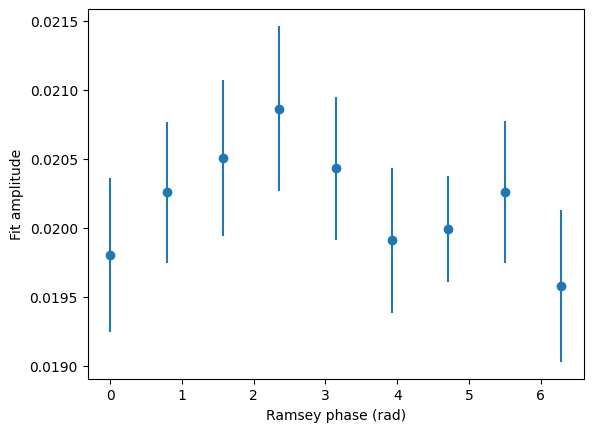

In [318]:
fig, ax = plt.subplots()
#ax.errorbar(phases, fit1_amps, fit1_amps_err, fmt="o", ls="none", label="a1")
#ax.errorbar(phases, fit2_amps, fit2_amps_err, fmt="o", ls="none", label="a2")

phases_summed = list(set(phases))
fit1_amps_avg = [[] for kk in phases_summed]
fit2_amps_avg = [[] for kk in phases_summed]
for kk in range(len(phases)):
    index = phases_summed.index(phases[kk])
    fit1_amps_avg[index].append(fit1_amps[kk])
    fit2_amps_avg[index].append(fit2_amps[kk])
fit1_amps_ste = [np.std(kk) / np.sqrt(len(kk)) for kk in fit1_amps_avg]
fit1_amps_avg = [np.average(kk) for kk in fit1_amps_avg]
fit2_amps_ste = [np.std(kk) / np.sqrt(len(kk)) for kk in fit2_amps_avg]
fit2_amps_avg = [np.average(kk) for kk in fit2_amps_avg]
#ax.errorbar(phases_summed, fit1_amps_avg, fit1_amps_ste, fmt="o", ls="none", label="a1")
ax.errorbar(phases_summed, fit2_amps_avg, fit2_amps_ste, fmt="o", ls="none", label="a2")
ax.set_xlabel("Ramsey phase (rad)")
ax.set_ylabel("Fit amplitude")
#ax.legend()
plt.show()

In [300]:
data_numbers = [2402]
all_data = [get_experiment_data(kk) for kk in data_numbers]
probes = [data_to_probe(kk) for kk in data_numbers]
#flop_times_ms = [data[1]["params"]["flop"]["on_time"].to("ms").magnitude for data in all_data]
offsets_kHz = [data[1]["params"]["flop"]["offset"].to("kHz").magnitude for data in all_data]
phases = [data[1]["params"]["flop"]["phase_difference"] for data in all_data]
#amplitudes = [data[1]["params"]["flop"]["amplitude"] for data in all_data]
#scans_kHz = [data[1]["params"]["flop"]["scan"].to("kHz").magnitude for data in all_data]
# #fitters = [get_interpolate_fit(probe) for probe in probes]
# fit_amplitudes = [fitter.results["a"] for fitter in fitters]
# fit_amplitude_errs = [fitter.errors["a"] for fitter in fitters]

fitters = [get_interpolate_fit_2(probe) for probe in probes]
fit1_amplitudes = [fitter[0].results["a1"] for fitter in fitters]
fit1_amplitude_errs = [fitter[0].errors["a1"] for fitter in fitters]
fit2_amplitudes = [fitter[1].results["a2"] for fitter in fitters]
fit2_amplitude_errs = [fitter[1].errors["a2"] for fitter in fitters]

identifier = "data " + data_identifier(data_numbers)

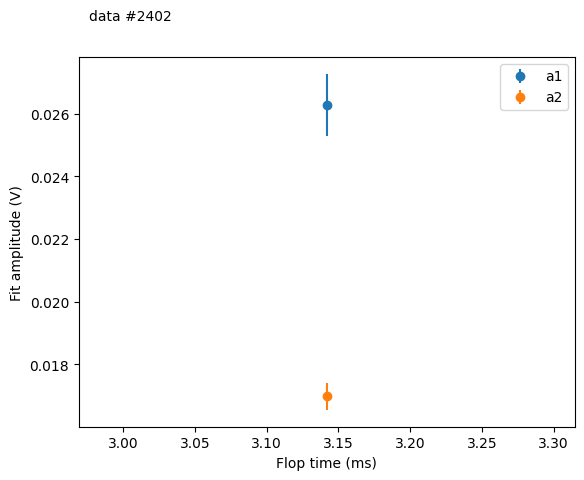

In [301]:
fitter_flop = Fitter(rabi_flopping)
#fitter_flop.set_data(flop_times_ms, fit_amplitudes, fit_amplitude_errs)
fitter_flop.set_p0({"amplitude_to_Omega": 0.2})
#fitter_flop.fit()

offsets_plt = np.linspace(min(offsets_kHz), max(offsets_kHz), 300)

fig, ax = plt.subplots()
add_label(ax)
# ax.errorbar(flop_times_ms, fit_amplitudes, fit_amplitude_errs, fmt="o", ls="none")
#ax.plot(amplitudes_plt, fitter_flop.fitted_value(amplitudes_plt))
#ax.errorbar(offsets_kHz, fit1_amplitudes, fit1_amplitude_errs, fmt="o", ls="none", label="a1")
#ax.errorbar(offsets_kHz, fit2_amplitudes, fit2_amplitude_errs, fmt="o", ls="none", label="a2")
ax.errorbar(phases, fit1_amplitudes, fit1_amplitude_errs, fmt="o", ls="none", label="a1")
ax.errorbar(phases, fit2_amplitudes, fit2_amplitude_errs, fmt="o", ls="none", label="a2")

fitter = Fitter(gaussian2)
fitter.set_data(offsets_kHz, fit1_amplitudes, fit1_amplitude_errs)
fitter.set_p0({"sigma": 30})
fitter.set_bounds("sigma", 0, np.inf)
#fitter.fit()
#ax.plot(offsets_plt, fitter.fitted_value(offsets_plt), color="C0")
#ax.text(0.05, 0.75, "a1\n"+fitter.all_results_str(), transform=ax.transAxes)

fitter.set_data(offsets_kHz, fit2_amplitudes, fit2_amplitude_errs)
#fitter.fit()
#ax.plot(offsets_plt, fitter.fitted_value(offsets_plt), color="C1")

#ax.text(0.05, 0.45, "a2\n"+fitter.all_results_str(), transform=ax.transAxes)
# print(fitter.all_results_str())

ax.set_xlabel("Flop time (ms)")
#ax.set_xlabel("Flop Offset (kHz)")
# ax.grid()
ax.set_ylabel("Fit amplitude (V)")
ax.legend()
plt.show()

In [302]:
index = -1
p = probes[index]
data_number = data_numbers[index]

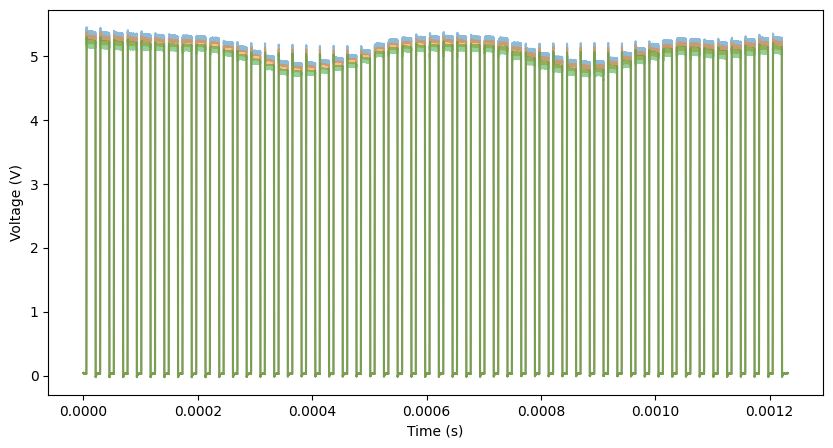

In [303]:
fig, ax = plt.subplots(figsize=(10, 5))
group_name = "antihole"
reshape_size = (
    p.transmission_groups[group_name].shape[0] * p.transmission_groups[group_name].shape[1],
    p.transmission_groups[group_name].shape[2]
)
ax.plot(p.times, p.transmission_groups[group_name].reshape(*reshape_size)[2:5].T, alpha=0.5)
#ax.plot(p.times, p.monitor_groups[group_name].reshape(*reshape_size)[:].T, alpha=0.5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (V)")
plt.show()

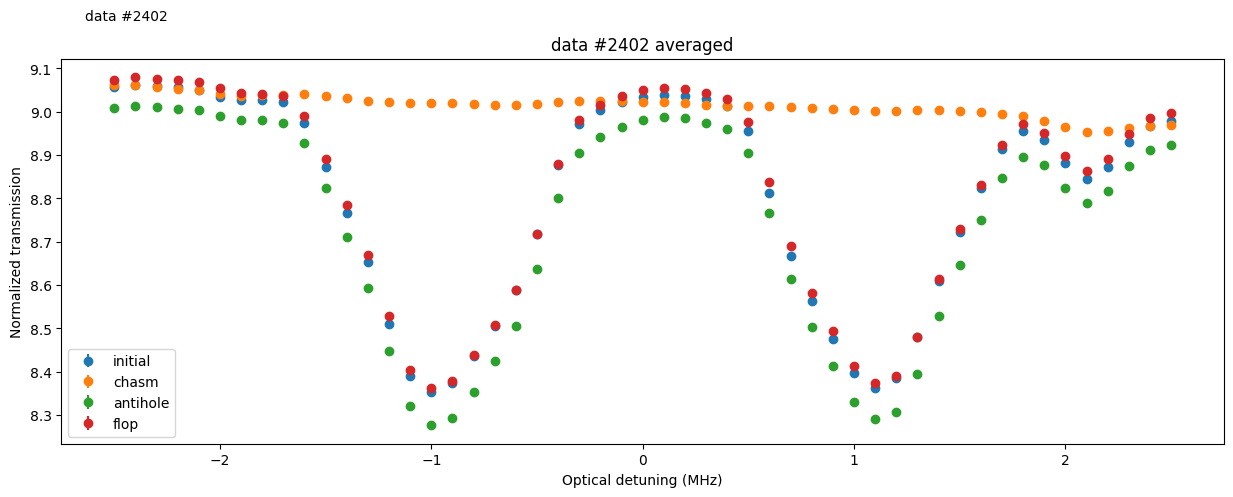

In [304]:
fig, ax = plt.subplots(figsize=(15, 5))
add_label(ax)
ax.errorbar(p.probes, p.normalized_averages("initial"), p.normalized_errors("initial"), label="initial", ls="none", marker="o")
ax.errorbar(p.probes, p.normalized_averages("chasm"), p.normalized_errors("chasm"), label="chasm", ls="none", marker="o")
ax.errorbar(p.probes, p.normalized_averages("antihole"), p.normalized_errors("antihole"), label="antihole", ls="none", marker="o")
ax.errorbar(p.probes, p.normalized_averages("flop"), p.normalized_errors("flop"), label="flop", ls="none", marker="o")
ax.legend()
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
ax.set_title(f"data #{data_number} averaged")
plt.show()

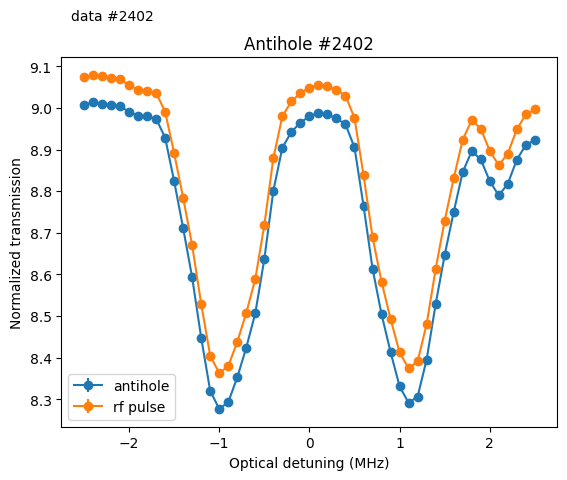

In [305]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100
signal = p.normalized_averages("antihole")
error = p.normalized_errors("antihole")
ax.errorbar(p.probes, signal, error, label=f"antihole", marker="o", zorder=zorder)
signal = p.normalized_averages("flop")
error = p.normalized_errors("flop")
ax.errorbar(p.probes, signal, error, label=f"rf pulse", marker="o", zorder=zorder)
ax.legend()
ax.set_title(f"Antihole #{data_number}")
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.show()

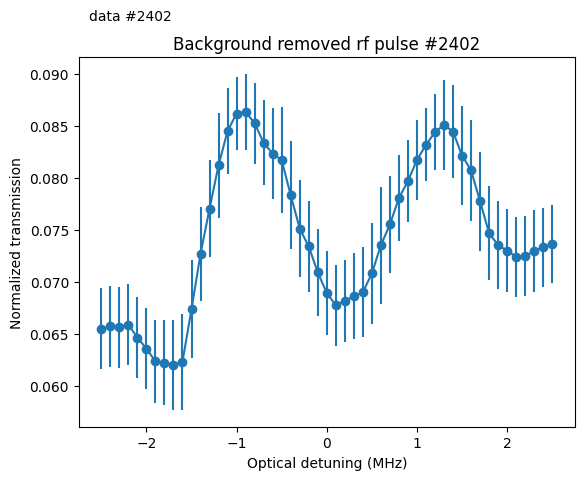

In [306]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100
signal = p.normalized_averages("flop") - p.normalized_averages("antihole")
error = np.sqrt(p.normalized_errors("flop") ** 2 + p.normalized_errors("antihole") ** 2)

#fitter = Fitter(interpolated_fit)
#fitter.set_data(p.probes, signal, error)
#fitter.fit()

ax.errorbar(p.probes, signal, error, marker="o")
#ax.plot(p.probes, fitter.fitted_value(p.probes))
ax.set_title(f"Background removed rf pulse #{data_number}")
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
#ax.text(0.05, 0.75, fitter.all_results_str(), transform=ax.transAxes)
plt.show()

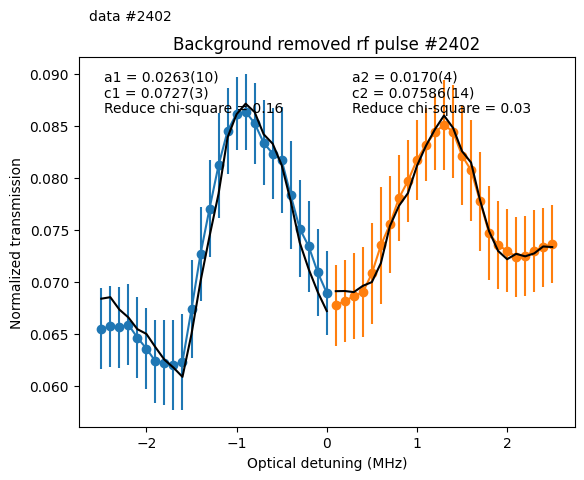

In [307]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100

ll = len(p.probes)//2 + 1

detuning1 = p.probes[:ll]
signal1 = p.normalized_averages("flop")[:ll] - p.normalized_averages("antihole")[:ll]
error1 = np.sqrt(p.normalized_errors("flop")[:ll] ** 2 + p.normalized_errors("antihole")[:ll] ** 2)

detuning2 = p.probes[ll:]
signal2 = p.normalized_averages("flop")[ll:] - p.normalized_averages("antihole")[ll:]
error2 = np.sqrt(p.normalized_errors("flop")[ll:] ** 2 + p.normalized_errors("antihole")[ll:] ** 2)

def signal_fit_function(detuning, signal):
    offsetted_signal = signal - np.average(signal)
    scaled_signal = offsetted_signal / (np.max(offsetted_signal) - np.min(offsetted_signal))
    return interp1d(detuning, scaled_signal)

# f1 = signal_fit_function(detuning1, signal1)
# f2 = signal_fit_function(detuning2, signal2)

# def interpolated_fit1(f, a1, c1):
#     return f1(f) * a1 + c1

# def interpolated_fit2(f, a2, c2):
#     return f2(f) * a2 + c2


fitter1 = Fitter(interpolated_fit1)
fitter1.set_data(detuning1, signal1, error1)
fitter1.set_absolute_sigma(False)
fitter1.fit()

fitter2 = Fitter(interpolated_fit2)
fitter2.set_data(detuning2, signal2, error2)
fitter2.set_absolute_sigma(False)
fitter2.fit()


ax.errorbar(detuning1, signal1, error1, marker="o")
ax.errorbar(detuning2, signal2, error2, marker="o")
ax.plot(detuning1, fitter1.fitted_value(detuning1), "k-", zorder=10)
ax.plot(detuning2, fitter2.fitted_value(detuning2), "k-", zorder=10)
ax.set_title(f"Background removed rf pulse #{data_number}")
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
ax.text(0.05, 0.85, fitter1.all_results_str(), transform=ax.transAxes)
ax.text(0.55, 0.85, fitter2.all_results_str(), transform=ax.transAxes)
plt.show()

In [599]:
import pickle
with open("f1.pkl", "wb") as f:
    pickle.dump(f1, f)
with open("f2.pkl", "wb") as f:
    pickle.dump(f2, f)

In [2660]:
#offsetted_signal = signal - np.average(signal)
#scaled_signal = offsetted_signal / (np.max(offsetted_signal) - np.min(offsetted_signal))
#fit_function = interp1d(p.probes, scaled_signal)
#def interpolated_fit(f, a, c):
#    return fit_function(f) * a + c

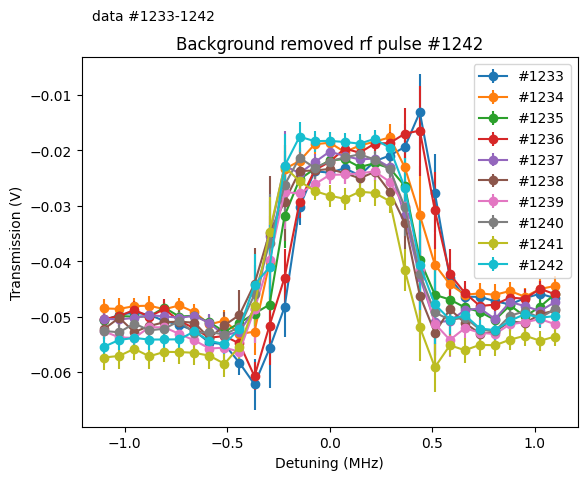

In [2395]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100
for kk, p in enumerate(probes):
    signal = p.averages("flop_no_bg")
    error = p.errors("flop_no_bg")

    ax.errorbar(p.probes, signal, error, marker="o", label=f'#{data_numbers[kk]}')
ax.set_title(f"Background removed rf pulse #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
ax.legend()
plt.show()